In [13]:
# coding: utf-8

import xarray as xr
import numpy as np
from glob import glob
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pickle
import calendar
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib as mpl
import copy
from matplotlib.colors import  ListedColormap

In [2]:
# Opening a dataset just to get the lat/lon of the grid
aux1 = xr.open_dataset('/chinook/marinier/CONUS_2D/CTRL/2000/wrf2d_d01_CTRL_T2_200010-200012.nc', engine='netcdf4') 
#store = '/chinook/cruman/Data/WetSnow'
#auxPlot = f'/{store}/WetSnow_SN_200010-200012.nc'
#auxPlot = xr.open_dataset(auxPlot)
#auxPlot['S_Events'] = (('south_north', 'west_east'), b)
#auxPlot['S_EventsAVG'] = (('south_north', 'west_east'), b/12)

In [3]:
fo = '/chinook/cruman/Data/Near0Events/Distribution'
# Get the average number of hours near 0
l = np.arange(-50,48,4)
xi = 1015 
yi = 1359 
dist = np.zeros((xi, yi, len(l)))
dist_pgw = np.zeros((xi, yi, len(l)))

# Year, Month, Lat, Lon
#for m in range(1,13):
#    l.append([])
t = 0
for i,y in enumerate(range(2000,2014)):
    print(f"Ano {i}")
    for m in range(1,13):
        if y == 2000 and m < 10:
            continue
        if y == 2013 and m > 9:
            continue
        #print(f"Mes: {m}, Ano: {y}")
        sim='CTRL'
        aux = pickle.load( open(f'{fo}/dist_{sim}_{y}_{m:02d}.p', 'rb'))
        #print(f'{fo}/t2m_{y}_{m:02d}.p')
        dist += aux
        sim = 'PGW'
        aux = pickle.load( open(f'{fo}/dist_{sim}_{y}_{m:02d}.p', 'rb'))
        dist_pgw += aux
        t+= 1
        #print(i, m-1)
        #d_array[m-1].append(aux)
    
print(f"Total # of months: {t}")        

Ano 0
Ano 1
Ano 2
Ano 3
Ano 4
Ano 5
Ano 6
Ano 7
Ano 8
Ano 9
Ano 10
Ano 11
Ano 12
Ano 13
Total # of months: 156


In [5]:
dist[714, 1087]

array([    0.,     0.,     0.,     0.,    91.,   322.,   767.,  1670.,
        2977.,  4291.,  5476.,  6661.,  8943., 12699., 10436.,  9849.,
       11155., 12496., 11595.,  8404.,  4616.,  1342.,   162.,     0.,
           0.])

In [5]:
maxindex = np.argmax(dist, axis=2)
near0_ctrl = np.where(maxindex==13, True, False)

maxindex = np.argmax(dist_pgw, axis=2)
near0_pgw = np.where(maxindex==13, True, False)

In [6]:
c1p1 = np.where((near0_pgw==1) & (near0_ctrl==1), 1, 0)
c1p0 = np.where((near0_pgw==0) & (near0_ctrl==1), 2, 0)
c0p1 = np.where((near0_pgw==1) & (near0_ctrl==0), 3, 0)
c0p0 = np.where((near0_pgw==0) & (near0_ctrl==0), 4, 0)

In [7]:
possibilities = c1p1+c0p1+c1p0+c0p0

In [38]:
aux1['possibilities'] = (('south_north', 'west_east'), possibilities)
maxindex = np.argmax(dist, axis=2)
near0_ctrl = np.where(maxindex==13, 2, 0)
aux1['ctrl'] = (('south_north', 'west_east'), near0_ctrl.astype(int))
maxindex = np.argmax(dist_pgw, axis=2)
near0_pgw = np.where(maxindex==13, 2, 0)
aux1['pgw'] = (('south_north', 'west_east'), near0_pgw.astype(int))

In [9]:
xll, yll = aux1.XLONG.values[0, 0],aux1.XLAT.values[0, 0]
xur, yur = aux1.XLONG.values[-1, -1],aux1.XLAT.values[-1, -1]

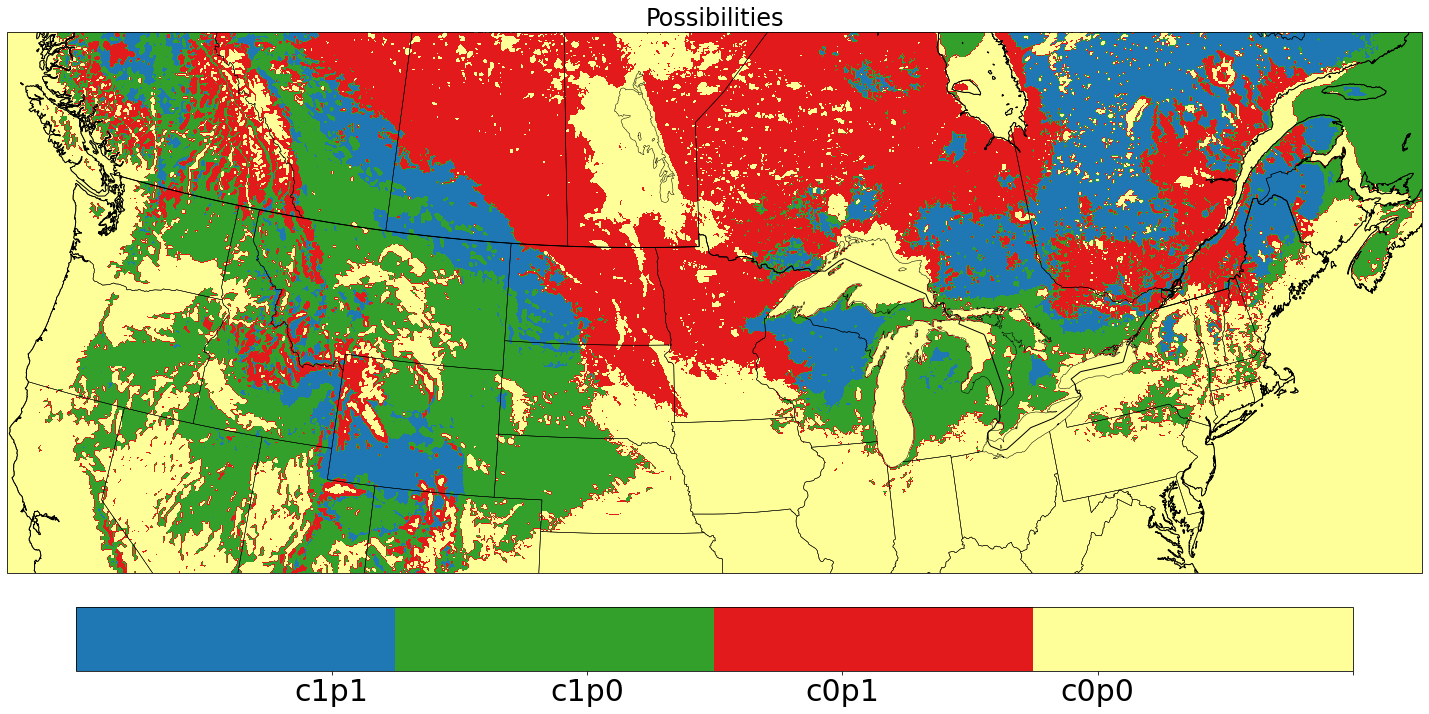

In [19]:
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 5 #np.max(aux1['total_day'].values)
val_min = 1
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Possibilities"

ax.set_extent([xll, xur-10, 36, yur])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=4)
# Plot figure
cs = aux1['possibilities'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
cb.ax.set_xticklabels(['c1p1', 'c1p0', 'c0p1', 'c0p0', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities.png')
#plt.show()

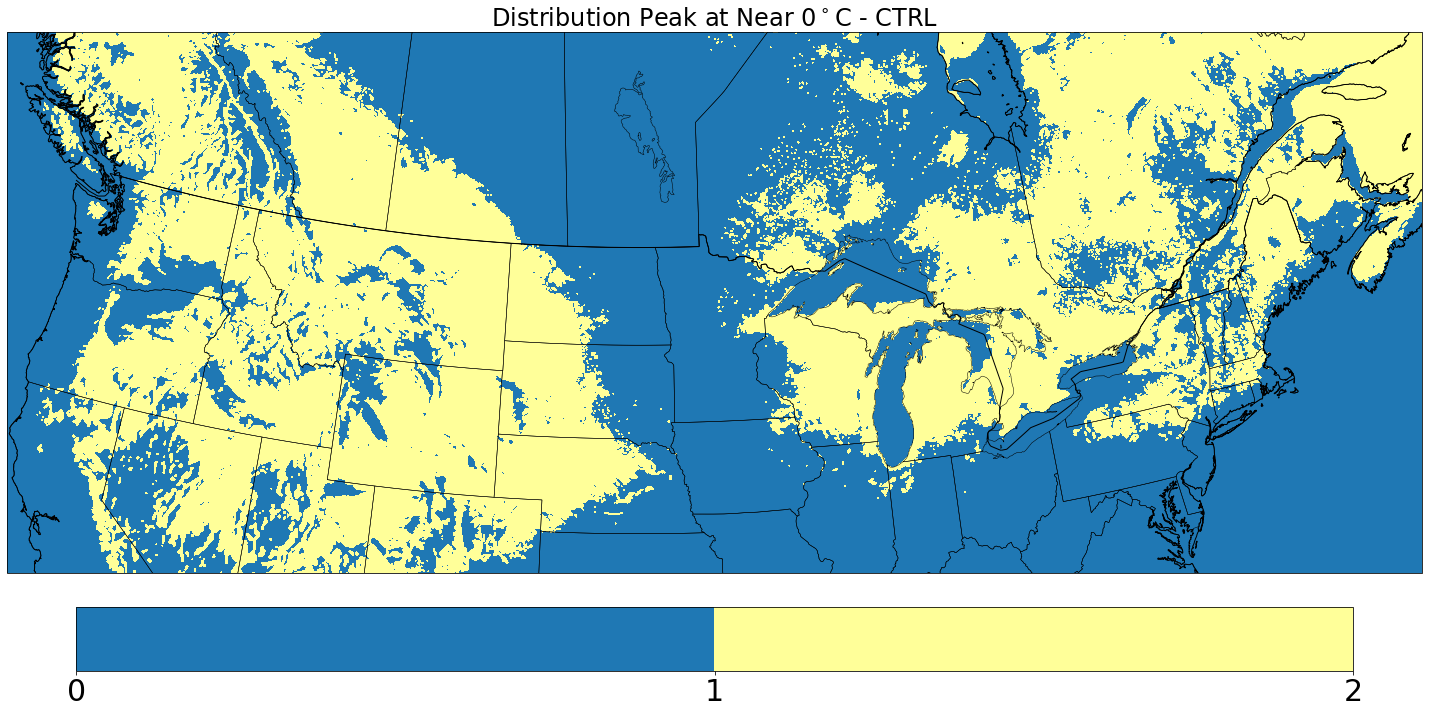

In [39]:
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw={'projection': myLambert})

width = 1.0  
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 2 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 1
#new_cmap = plt.cm.jet
cor = ['#8dd3c7','#ffffb3','#bebada','#fb8072']
cor = ['#1f78b4', '#33a02c', '#e31a1c', '#ffff99']
#cor = ['#ef8a62', '#67a9cf']
new_cmap = mpl.colors.ListedColormap(cor)
unit = ""
title = r"Distribution Peak at Near 0${\rm ^\circ C}$ - CTRL"

ax.set_extent([xll, xur-10, 36, yur])

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
# Plot figure
cs = aux1['ctrl'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
           add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9)
cb.ax.set_title(unit, fontsize=30)
cb.ax.tick_params(labelsize=30) 
#cb.ax.set_xticklabels(['c1p1', 'c1p0', 'c0p1', 'c0p0', ' '])
# Plot title
ax.set_title(title, fontsize=24)

ax.coastlines(resolution='10m', linewidth=width)
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
#ax.add_feature(cfeature.OCEAN, zorder=10)

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('possibilities_ctrl.png')
#plt.show()

In [22]:
aux1['ctrl']

<xarray.DataArray 'ctrl' (south_north: 1015, west_east: 1359)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])
Coordinates:
    XLAT     (south_north, west_east) float32 18.14 18.15 18.15 ... 52.43 52.42
    XLONG    (south_north, west_east) float32 -122.9 -122.8 ... -57.0 -56.95
Dimensions without coordinates: south_north, west_east

<ipython-input-14-8df7b9cbbea6>:44: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = f.colorbar(cs, cax=cbar_ax, ticks=color_ticks, orientation='horizontal',pad=0.05,shrink=0.9, extend="both")
<ipython-input-14-8df7b9cbbea6>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


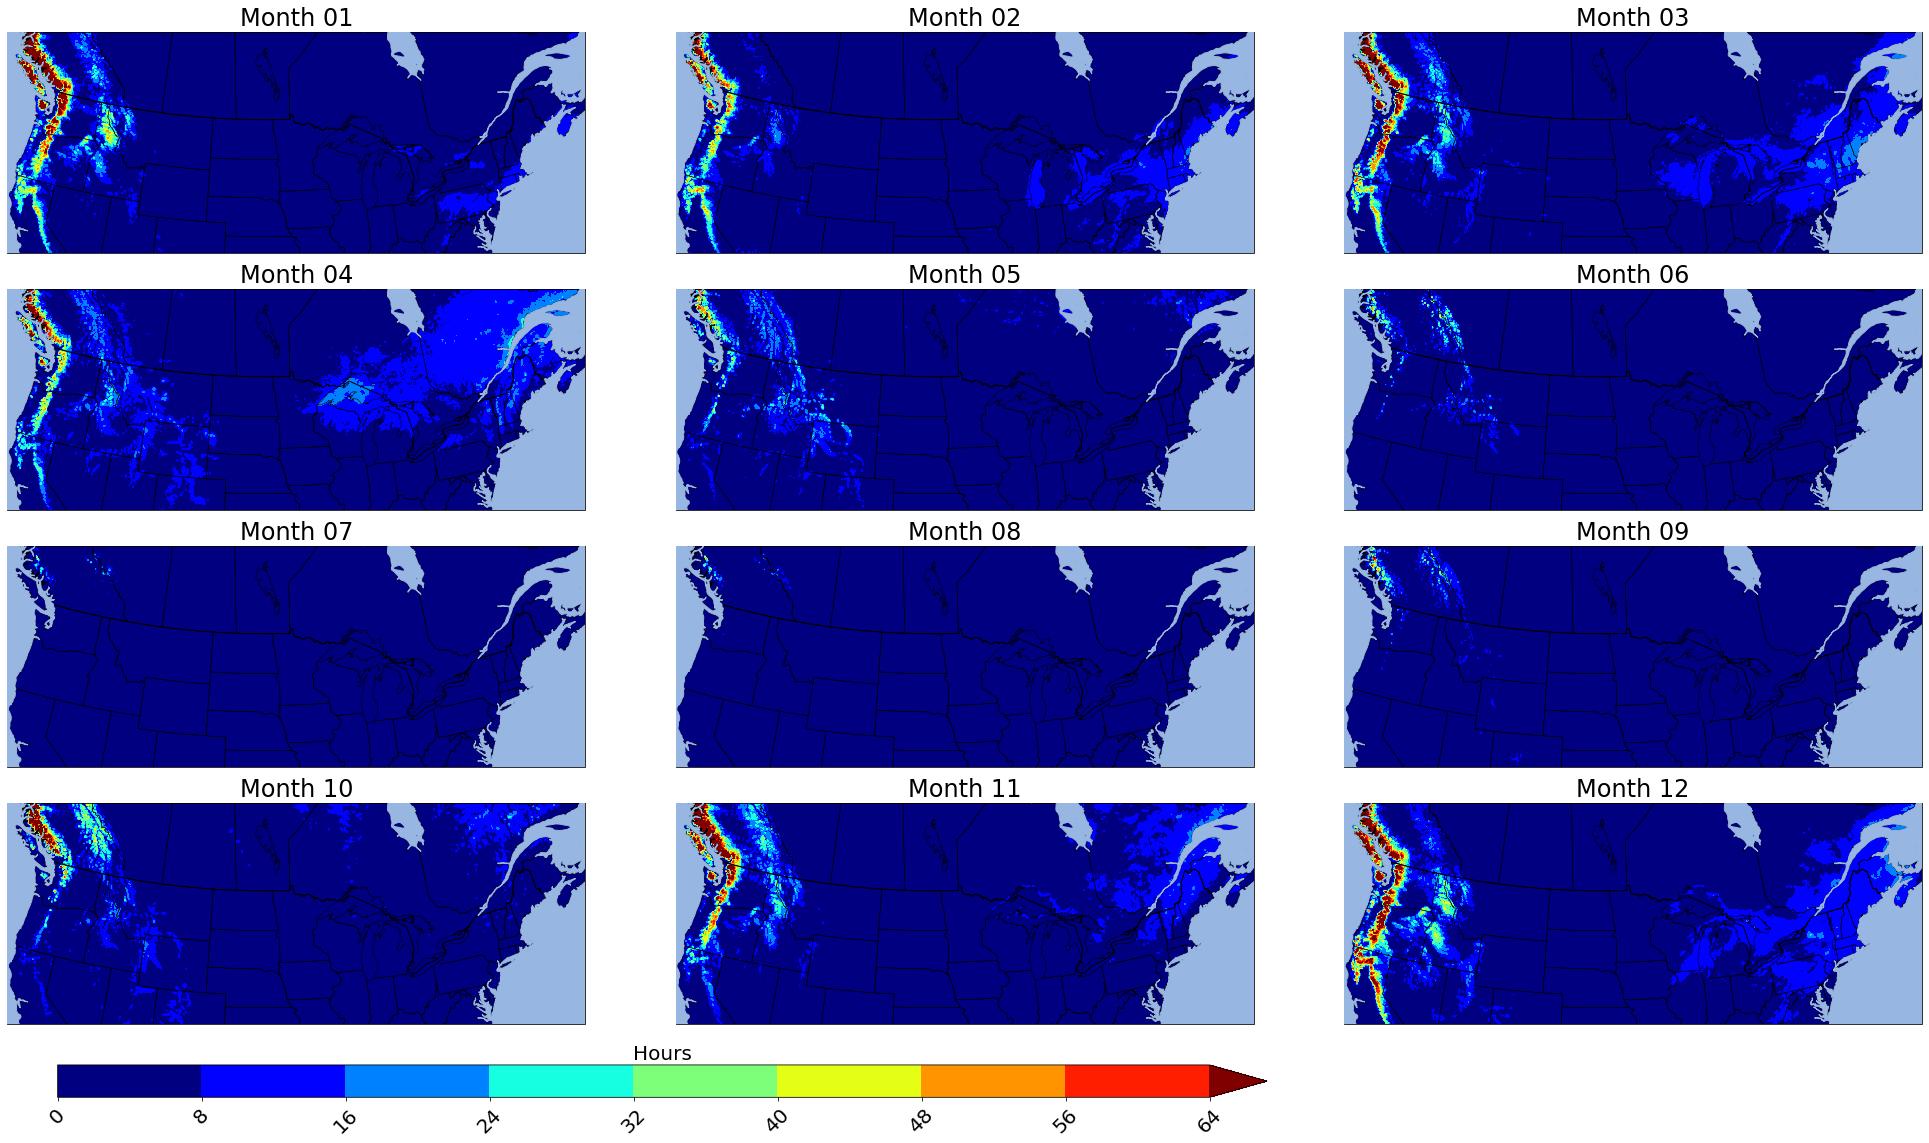

In [14]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, axs = plt.subplots(5, 3, figsize=(28, 18), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
new_cmap = mpl.cm.get_cmap("viridis_r")
#new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
#new_cmap.set_bad(color='white')

val_max = 64 #np.max(aux1['total_day'].values)
val_min = 0
val_int = 8
new_cmap = plt.cm.jet
unit = "Hours"
title = r"Average monthly number of Hour with near 0 ${\rm ^\circ C}$. 10-2000 to 09-2013"

ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)

for i, ax in enumerate(axs.flat):
    if i > 11:
        f.delaxes(ax)
        continue
    ax.set_extent([xll, xur-10, 36, yur])

# Plot figure
    cs = aux1[f'total_month_{i:02d}'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
               add_colorbar=False, cmap=new_cmap, levels=int(ints), vmin=0, vmax=val_max, extend='max')
    
    ax.coastlines(resolution='10m', linewidth=width)
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
    ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
    ax.add_feature(cfeature.OCEAN, zorder=10)
    ax.set_title(f"Month {i+1:02d}", fontsize=24)
#cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cbar_ax = f.add_axes([0.05, 0.15, 0.6, 0.025])
cb = f.colorbar(cs, cax=cbar_ax, ticks=color_ticks, orientation='horizontal',pad=0.05,shrink=0.9, extend="both")
#cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="horizontal",pad=0.05,shrink=0.9, extend="both")
cb.ax.set_title(unit, fontsize=20)
cb.ax.tick_params(labelsize=20, labelrotation=45) 
# Plot title

#ax.set_title(f"Month: {i+1:02d}", fontsize=20)

plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
#cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
#cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
#cb.set_label('Number of Events', size=36)
#cbar_ax.tick_params(labelsize=30) 

plt.savefig('near_zero_hours_monthly_pr1_t.png')
#plt.show()

In [ ]:
# Plotting Monthly Events
myLambert = ccrs.LambertConformal(central_longitude=-98.0, central_latitude=39.700012)

  # Making the subplots
f, axs = plt.subplots(5, 3, figsize=(14, 20), subplot_kw={'projection': myLambert})

width = 1.0  
new_cmap = 'viridis_r'
#new_cmap = mpl.cm.get_cmap("viridis_r")
new_cmap = copy.copy(mpl.cm.get_cmap("viridis_r"))
new_cmap.set_bad(color='white')

for i, ax in enumerate(axs.flat):        
    #ax.set_extent([-69.5, -63.5, 45, 48.2])
    if i >= 12:
        f.delaxes(ax)
        continue
        
    # Masking values == 0
    im = auxPlot[f'PR_Events{i+1:02d}'].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), x='XLONG', y='XLAT',
               add_colorbar=False, cmap=new_cmap, levels=7, vmin=0, vmax=6, extend='max')

    ax.coastlines(resolution='10m', linewidth=width)
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=width)
    ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=width/2)
    ax.add_feature(cfeature.OCEAN, zorder=10)

    ax.set_title(f"Month: {i+1:02d}", fontsize=20)


plt.tight_layout()    
#cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
cbar_ax = f.add_axes([0.20, 0.15, 0.6, 0.025])
cb = f.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.set_label('Number of Events', size=36)
cbar_ax.tick_params(labelsize=30) 

plt.savefig('PRevents_plot_avg_monthly.png')
#plt.show()